This is my take to implement ConvNets to solve CIFAR10 classification task

# Fully Connected Network

## Load data

For this part I use Stanfords CS231n gugid to load the cifar10 data

In [1]:
from fullyConnected import early_stop, build_fc_model_batchnorm, build_CNN, build_CNN_batchnorm
from fullyConnected import build_2xCNN_batchnorm, build_CNN_nopool, update_functions
from fullyConnected import build_fc_model, update_functions, shared_dataset
from lasagne.layers import  get_all_param_values, count_params, get_all_layers, get_all_params
import numpy as np
from data_utils import get_CIFAR10_data
import theano.tensor as T
import time
import cPickle as pickle
# plot the training results
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5005)


In [2]:
# to auto reload external modules
%load_ext autoreload
%autoreload 2

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


## MLP

In [4]:
num_class = np.unique(data['y_train']).size

X = T.ftensor4('X')
y = T.ivector('y')

In [5]:
# load data to gpu for fast minibatch training
shared_data = shared_dataset(data)
del data

In [8]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]

network = build_fc_model(in_shape=input_shape,
                         num_hidden=hidden_arch,
                         num_out=num_class,
                         in_var=X)

In [12]:
net,test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                     data=shared_data,
                                                                                     X=X, y=y,
                                                                                     batch_size=2048,
                                                                                     l1_reg=0,
                                                                                     l2_reg=.01,
                                                                                     lear_rate=1e-3,
                                                                                     iteration=100,
                                                                                     printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 1, val_loss 1.603677, train_loss 1.723107, error 0.557000, best error 0.557000 ,in 0.163427 secs 

epoch 21, val_loss 1.553563, train_loss 1.499415, error 0.537000, best error 0.482000 ,in 3.148137 secs 

epoch 41, val_loss 1.481901, train_loss 1.513407, error 0.524000, best error 0.482000 ,in 3.155068 secs 

epoch 61, val_loss 1.493237, train_loss 1.516923, error 0.515000, best error 0.472000 ,in 3.149929 secs 

epoch 81, val_loss 1.557146, train_loss 1.495328, error 0.526000, best error 0.472000 ,in 3.142401 secs 



In [13]:
min(train_loss_history_), min(val_loss_history_), min(val_error_history_)

(1.4699889, array(1.3689178228378296, dtype=float32), array(0.472))

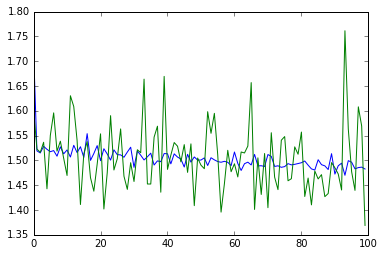

In [14]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [15]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 52.8 %
best test accuracy: 53.2 %


## Add Dropout

In [16]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
# note that Dropout helps to regularize the network, therefore
# it should not improve performance if the architecture is fixed as the previous model
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]
dropout = [.1,.3,.3]

network = build_fc_model(in_shape=input_shape,
                         num_hidden=hidden_arch,
                         num_out=num_class,
                         dropout=dropout,
                         in_var=X)

In [24]:
net,test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                     data=shared_data,
                                                                                     X=X, y=y,
                                                                                     batch_size=2048,
                                                                                     l1_reg=0,
                                                                                     l2_reg=.01,
                                                                                     lear_rate=1e-3,
                                                                                     iteration=100,
                                                                                     printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 1, val_loss 1.538582, train_loss 1.711603, error 0.534000, best error 0.534000 ,in 0.290551 secs 

epoch 21, val_loss 1.502558, train_loss 1.647700, error 0.519000, best error 0.499000 ,in 5.619328 secs 

epoch 41, val_loss 1.512357, train_loss 1.648814, error 0.528000, best error 0.491000 ,in 5.887325 secs 

epoch 61, val_loss 1.663144, train_loss 1.650641, error 0.556000, best error 0.491000 ,in 6.076196 secs 

epoch 81, val_loss 1.401283, train_loss 1.649262, error 0.484000, best error 0.484000 ,in 5.978246 secs 



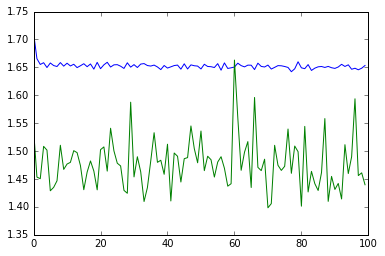

In [25]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [26]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 51.6 %
best test accuracy: 48.0 %


## batch normalisation

Here I add batch normalisation to the MLP model, without any convolution layer, to see what happens.
I don't expect to drastic change as the batch-normalisation technique speeds-up learning, and not much more.

In [18]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]

network = build_fc_model_batchnorm(in_shape=input_shape,
                                   num_hidden=hidden_arch,
                                   num_out=num_class,
                                   in_var=X)

In [21]:
net,test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                     data=shared_data,
                                                                                     X=X, y=y,
                                                                                     batch_size=2048,
                                                                                     l1_reg=0,
                                                                                     l2_reg=.01,
                                                                                     lear_rate=1e-3,
                                                                                     iteration=100,
                                                                                     printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 1, val_loss 1.424564, train_loss 1.758554, error 0.495000, best error 0.495000 ,in 0.291607 secs 

epoch 21, val_loss 1.504065, train_loss 1.661150, error 0.536000, best error 0.478000 ,in 5.706652 secs 

epoch 41, val_loss 1.428217, train_loss 1.663188, error 0.503000, best error 0.478000 ,in 5.639629 secs 

epoch 61, val_loss 1.429774, train_loss 1.662209, error 0.509000, best error 0.478000 ,in 5.818938 secs 

epoch 81, val_loss 1.440475, train_loss 1.653599, error 0.510000, best error 0.478000 ,in 5.985794 secs 



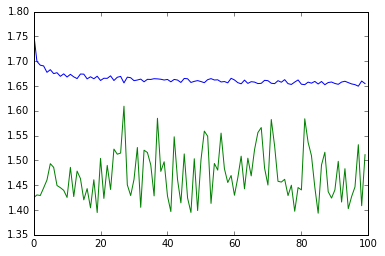

In [22]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [23]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 52.2 %
best test accuracy: 46.5 %


# CNN

Build a simple 3layer CNN

architechture:
    conv - relu - 2x2 maxpool - affine - relu - affine - softmax
    
Note that I only use a single convolution layer, here we can see what is changing compared to previous models.
One convolution layer only can see a very small spatioal region in the image, here a 7x7 region. 
It is interesting to see how it compares to a fully connected network.

In [12]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = [128,256]
num_filter = 32

network = build_CNN(in_shape=input_shape,
                    num_hidden=hidden_arch,
                    num_filter = num_filter,
                    fil_size = 7,
                    num_out=num_class,
                    in_var=X)

In [16]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.001,
                                                                                 lear_rate=1e-3,
                                                                                 iteration=100,
                                                                                 printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 1.412611, train_loss 1.522405, error 0.522000, best error 0.522000 ,in 3.415571 secs 

epoch 21, val_loss 1.298695, train_loss 1.205357, error 0.430000, best error 0.402000 ,in 68.630920 secs 

epoch 41, val_loss 1.192607, train_loss 1.166085, error 0.402000, best error 0.385000 ,in 69.168571 secs 

epoch 61, val_loss 1.173393, train_loss 1.148397, error 0.391000, best error 0.370000 ,in 69.391259 secs 

epoch 81, val_loss 1.155466, train_loss 1.137996, error 0.394000, best error 0.369000 ,in 68.495842 secs 



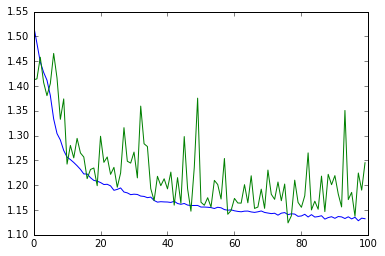

In [17]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [18]:
# using only one convolution layer we get better performance fro
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 63.1 %
best test accuracy: 60.9 %


## CNN + Batch normalisation

Build a simple 3layer CNN with batch normalisation

architechture:

    conv - relu - 2x2 maxpool - affine - relu - affine - softmax

In [268]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = 32

network = build_CNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = 7,
                              num_out=num_class,
                              in_var=X)

In [269]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-2,
                                                                                 iteration=100,
                                                                                 printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 10, val_loss 1.305629, train_loss 0.278293, error 0.351000, best error 0.348000 ,in 84.481983 secs 

epoch 20, val_loss 1.520522, train_loss 0.242956, error 0.359000, best error 0.342000 ,in 84.147702 secs 

epoch 30, val_loss 1.431203, train_loss 0.222392, error 0.351000, best error 0.322000 ,in 84.772461 secs 

epoch 40, val_loss 1.488086, train_loss 0.198525, error 0.334000, best error 0.322000 ,in 84.041291 secs 

epoch 50, val_loss 1.591749, train_loss 0.202776, error 0.348000, best error 0.322000 ,in 83.780562 secs 

epoch 60, val_loss 1.333655, train_loss 0.189722, error 0.321000, best error 0.301000 ,in 83.713607 secs 

epoch 70, val_loss 1.291978, train_loss 0.170806, error 0.322000, best error 0.301000 ,in 82.216305 secs 

epoch 80, val_loss 1.435140, train_loss 0.164189, error 0.337000, best error 0.301000 ,in 81.244518 secs 

epoch 90, val_loss 1.590224, tr

## Deeper CNN + Batch normalisation
Build a simple 4layer CNN with batch normalisation

fist conv layer has 7x7 filters and the second has 3x3 filters

architechture:

        (conv - relu - 2x2 maxpool)x2 - affine - relu - affine - softmax

In [294]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = 32

network = build_2xCNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = 7,
                              num_out=num_class,
                              in_var=X)

In [299]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=2048,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-2,
                                                                                 iteration=50,
                                                                                 printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 10, val_loss 1.215559, train_loss 0.132976, error 0.281000, best error 0.280000 ,in 53.014396 secs 

epoch 20, val_loss 1.195995, train_loss 0.121440, error 0.276000, best error 0.274000 ,in 51.729225 secs 

epoch 30, val_loss 1.176005, train_loss 0.111231, error 0.273000, best error 0.273000 ,in 51.722908 secs 

epoch 40, val_loss 1.157622, train_loss 0.102030, error 0.267000, best error 0.267000 ,in 51.721194 secs 

epoch 50, val_loss 1.140275, train_loss 0.093704, error 0.276000, best error 0.267000 ,in 51.696729 secs 



In [300]:
weights = get_all_param_values(net)

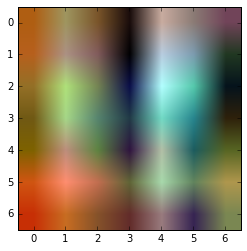

In [310]:
ind = np.random.randint(0, high=31)
im = weights[0][ind,:,:,:].reshape(3,7,7)
im = im.swapaxes(0,2)
im+=abs(im.min(axis=(0,1)))
im *= 255/im.max(axis=(0,1))
plt.imshow(im.astype('uint8'))

## Deeper CNN + Batch normalisation
Build a simple 4layer CNN with batch normalisation with more filters

fist conv layer has 7x7 filters and the second has 3x3 filters

architechture:

        (conv - relu - 2x2 maxpool)x2 - affine - relu - affine - softmax

In [40]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = [64, 128]
filters = [3,3]

network = build_2xCNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = filters,
                              num_out=num_class,
                              in_var=X)

In [12]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=256,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-3,
                                                                                 iteration=150,
                                                                                 printFreq=30)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 192
start training
epoch 30, val_loss 1.173052, train_loss 0.200253, error 0.331000, best error 0.223000 ,in 521.889631 secs 

epoch 60, val_loss 2.866783, train_loss 0.204561, error 0.542000, best error 0.205000 ,in 521.086501 secs 

epoch 90, val_loss 0.685515, train_loss 0.056368, error 0.211000, best error 0.205000 ,in 520.818964 secs 

epoch 120, val_loss 0.650800, train_loss 0.033078, error 0.205000, best error 0.195000 ,in 529.004199 secs 

epoch 150, val_loss 0.666947, train_loss 0.030752, error 0.205000, best error 0.195000 ,in 527.117913 secs 



In [14]:
test_fn()[1]

array(0.225)

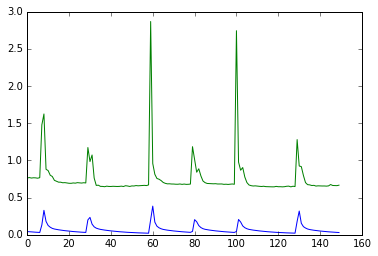

In [16]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

# Build a simpler CNN by avoiding pooling

Here I try to replicate the approach in [ref](http://arxiv.org/pdf/1412.6806.pdf). However, I added batch normalisation to the mix.

basically instead of pooling convolutions with stride 2 are used. In addition, fully connected layer is omitted

In [23]:
# build model
input_shape = (None, 3,32,32)

network = build_CNN_nopool(in_shape=input_shape,
                           num_filter=[64, 128,128,256],
                           fil_size=  [ 3,  3,  3,  8],
                           strides=   [ 1,  2,  1,  2],                                                  
                           num_out=num_class,
                           in_var=X)

In [24]:
count_params(network)

2414538

In [25]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                      data=shared_data,
                                                                                      X=X, y=y,
                                                                                      batch_size=128,
                                                                                      l1_reg=0,
                                                                                      l2_reg=0.0001,
                                                                                      lear_rate=1e-4,
                                                                                      iteration=50,
#                                                                                       name='fullCNN',
                                                                                      saveHistory=False,
                                                                                      printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 1.032938, train_loss 1.754451, error 0.362000, best error 0.362000 ,in 59.880579 secs 

epoch 11, val_loss 0.895131, train_loss 0.237508, error 0.214000, best error 0.208000 ,in 614.877519 secs 

epoch 21, val_loss 0.997641, train_loss 0.202398, error 0.219000, best error 0.196000 ,in 592.030136 secs 

epoch 31, val_loss 0.683265, train_loss 0.068825, error 0.180000, best error 0.180000 ,in 613.771954 secs 

epoch 41, val_loss 0.904230, train_loss 0.153089, error 0.222000, best error 0.176000 ,in 576.628326 secs 



In [16]:
# if you want to continue from a previous run
with open("fullCNN.p", "rb") as f:
    _,train_loss_history_,val_loss_history_, val_error_history_,network = pickle.load(f)
X = get_all_layers(network)[0].input_var

In [15]:
# evaluate test prediction
_, val_fn, test_fn = update_functions(net=network,data=shared_data,
                                      in_var=X, target=y)


In [27]:
print 'test/val prediction',test_fn()[1],'/',val_fn()[1]

 test/val prediction 0.185 /


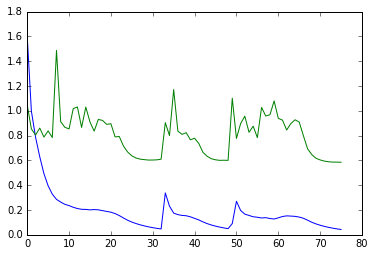

In [17]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)